In [19]:
# !conda install -c conda-forge umap-learn --yes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

2023-12-03 21:22:36.935975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('./EEG_data.csv')
data=pd.read_csv('./demographic_info.csv')

In [3]:
data = data.rename(columns = {'subject ID': 'SubjectID',' gender':'gender',' age':'age',' ethnicity':'ethnicity'})
df = df.merge(data,how = 'inner',on = 'SubjectID')

In [4]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


In [5]:
df['gender']=df['gender'].replace({'M':1,'F':0})
df['ethnicity']=df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})
df.drop(columns = ['SubjectID','VideoID','predefinedlabel'],inplace=True)

In [6]:
target=df['user-definedlabeln']

<Axes: title={'center': 'Correlation with Target'}>

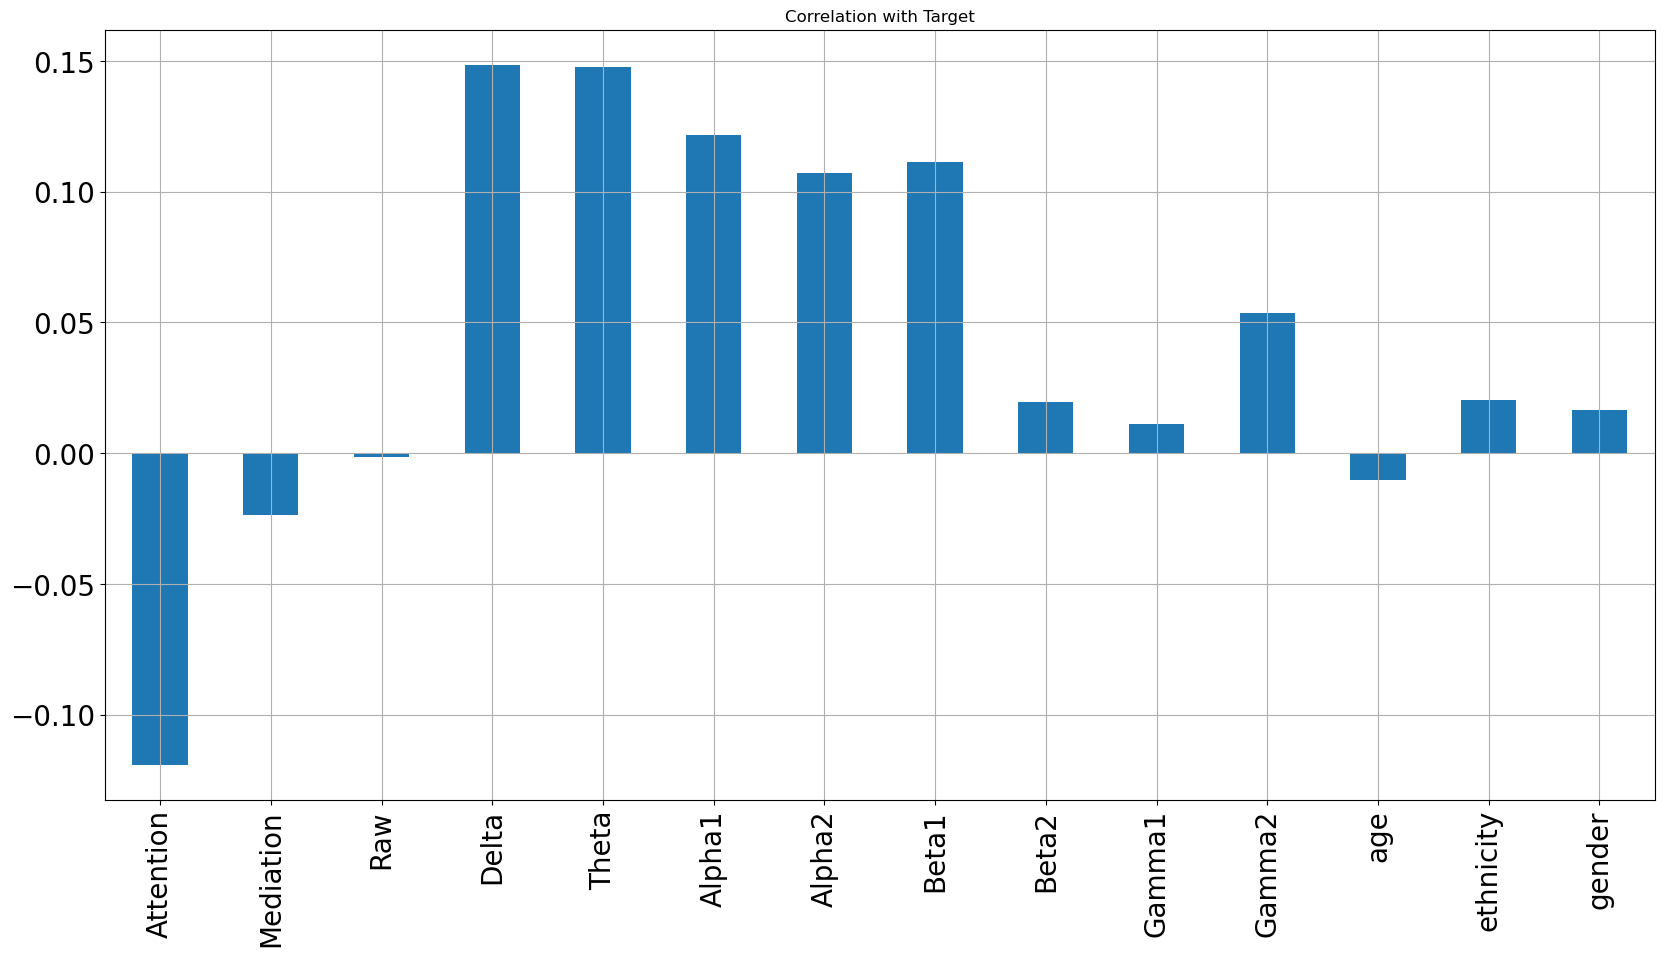

In [7]:
X=df.drop(['user-definedlabeln'],axis=1)
X.corrwith(df['user-definedlabeln']).plot.bar(
        figsize = (20, 10), title = "Correlation with Target", fontsize = 20,
        rot = 90, grid = True)

Referred from : https://www.geeksforgeeks.org/principal-component-analysis-pca/

## PCA

In [8]:
# Mean
X_mean = X.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std


In [9]:
Z.shape

(12811, 14)

The covariance matrix helps us visualize how strong the dependency of two features is with each other in the feature space.

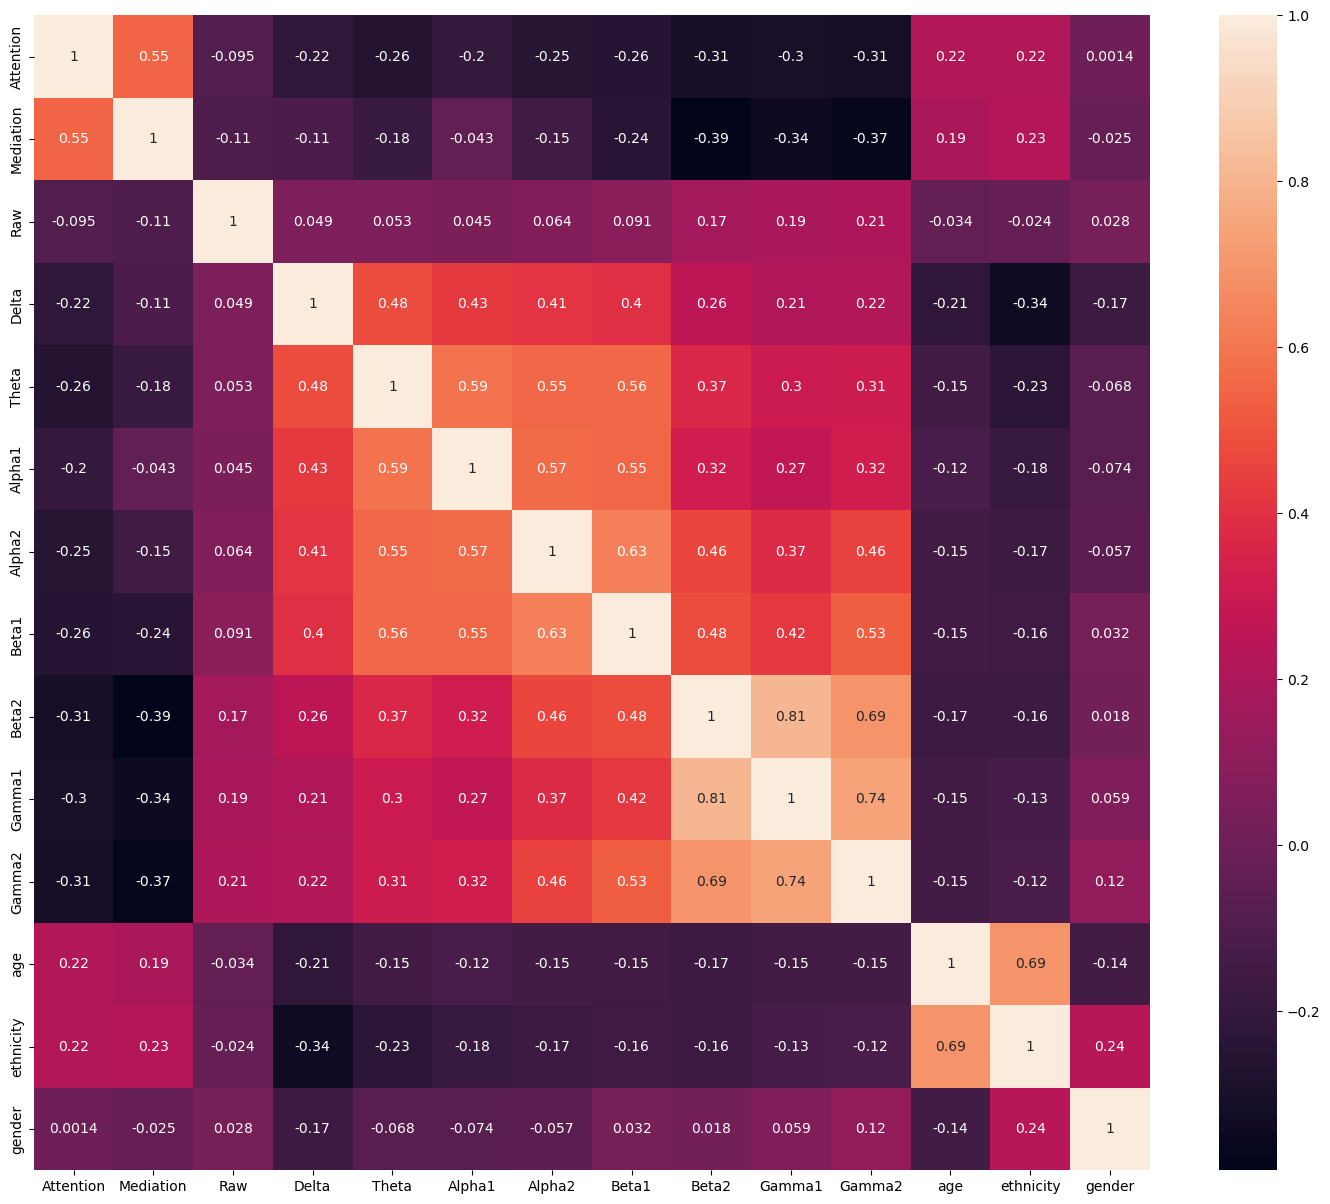

In [10]:
c = Z.cov()
 
# Plot the covariance matrix
plt.figure(figsize=(18,15))
sns.heatmap(c,annot=True)
plt.show()

In [11]:
c

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,age,ethnicity,gender
Attention,1.000000,0.548606,-0.094933,-0.220403,-0.258356,-0.198662,-0.247011,-0.255361,-0.306624,-0.299903,-0.312734,0.217467,0.222327,0.001373
Mediation,0.548606,1.000000,-0.106923,-0.111810,-0.179887,-0.043275,-0.153740,-0.240774,-0.391365,-0.344922,-0.373253,0.194248,0.228536,-0.025248
Raw,-0.094933,-0.106923,1.000000,0.048908,0.053443,0.045247,0.063867,0.090863,0.173631,0.186884,0.205772,-0.033516,-0.023661,0.028415
Delta,-0.220403,-0.111810,0.048908,1.000000,0.483386,0.426530,0.409898,0.395217,0.260820,0.210062,0.218673,-0.212532,-0.337524,-0.172337
Theta,-0.258356,-0.179887,0.053443,0.483386,1.000000,0.586956,0.553796,0.555541,0.368975,0.300468,0.308575,-0.147963,-0.228738,-0.068314
Alpha1,-0.198662,-0.043275,0.045247,0.426530,0.586956,1.000000,0.565232,0.549113,0.317923,0.267677,0.323593,-0.120965,-0.180693,-0.073588
Alpha2,-0.247011,-0.153740,0.063867,0.409898,0.553796,0.565232,1.000000,0.626824,0.464840,0.374979,0.455567,-0.145244,-0.169807,-0.057100
Beta1,-0.255361,-0.240774,0.090863,0.395217,0.555541,0.549113,0.626824,1.000000,0.480490,0.422165,0.527484,-0.148409,-0.161710,0.032436
Beta2,-0.306624,-0.391365,0.173631,0.260820,0.368975,0.317923,0.464840,0.480490,1.000000,0.808930,0.692584,-0.165426,-0.163402,0.017744
Gamma1,-0.299903,-0.344922,0.186884,0.210062,0.300468,0.267677,0.374979,0.422165,0.808930,1.000000,0.739836,-0.147075,-0.134076,0.059006


Now we will compute the `eigenvectors` and `eigenvalues` for our feature space which serve a great purpose in identifying the principal components for our feature space.

In [11]:
eigenvalues, eigenvectors = np.linalg.eig(c)
print('Eigen values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

Eigen values:
 [4.7682621  1.74196905 1.62883445 1.07333627 0.98162116 0.8992218
 0.16852763 0.20789281 0.28328842 0.34628998 0.39166226 0.47508206
 0.4552567  0.57875531]
Eigen values Shape: (14,)
Eigen Vector Shape: (14, 14)


In [12]:
# Index the eigenvalues in descending order 
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order 
eigenvalues = eigenvalues[idx]

# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]


In [13]:
eigenvectors

array([[-2.34631657e-01,  8.83650861e-02, -2.92082831e-01,
        -3.01571307e-01, -4.50186385e-01,  3.10519253e-01,
         3.68695370e-04,  5.04139145e-01, -2.90151793e-01,
         1.49526311e-01,  3.04559160e-01,  4.25413157e-02,
        -5.31693090e-02,  6.07977053e-02],
       [-2.18419108e-01,  2.33355114e-01, -3.63125448e-01,
        -3.10232287e-01, -3.60335863e-01,  1.39330072e-01,
         5.25141825e-02, -4.68708122e-01,  2.44123047e-01,
        -2.08057389e-01, -4.21159061e-01,  3.46169247e-03,
         7.10349764e-02, -1.12772473e-01],
       [ 9.11745958e-02, -2.05534547e-01,  4.67976165e-02,
         8.20199296e-02, -6.39465148e-01, -7.23374845e-01,
        -6.96632987e-02,  2.67486850e-02, -7.02411506e-03,
        -3.02125822e-02,  1.73931426e-02, -3.72570752e-02,
         8.07953404e-03,  7.21942349e-03],
       [ 2.55621972e-01,  3.58758141e-01, -5.19823715e-02,
         8.76268312e-02, -5.44936358e-02, -9.47728898e-02,
         8.34365398e-01,  1.18671340e-01,  2.

In [14]:
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
explained_var

array([0.34059015, 0.46501651, 0.58136183, 0.65802871, 0.7281445 ,
       0.79237463, 0.8337143 , 0.86764873, 0.90016706, 0.92814294,
       0.95287794, 0.97311283, 0.98796231, 1.        ])

#### Determine the Number of Principal Components 
Here we can either consider the number of principal components of any value of our choice or by limiting the explained variance. Here I am considering explained variance more than equal to 50%. Let’s check how many principal components come into this.

In [16]:
# n_components = np.argmax(explained_var >= 0.50) + 1
n_components=10

##### Project the Data onto the Selected Principal Components

- Find the projection matrix, It is a matrix of eigenvectors corresponding to the largest eigenvalues of the covariance matrix of the data. it projects the high-dimensional dataset onto a lower-dimensional subspace.
- The eigenvectors of the covariance matrix of the data are referred to as the principal axes of the data, and the projection of the data instances onto these principal axes are called the principal components. 

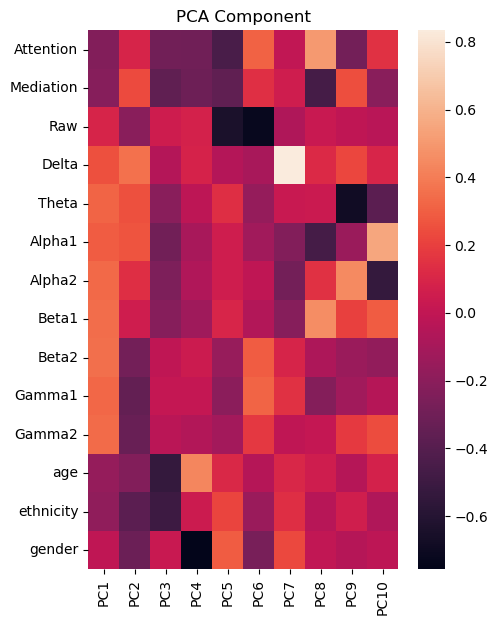

In [18]:
# PCA component or unit matrix
u = eigenvectors[:,:n_components]
pca_component = pd.DataFrame(u,
							index = X.columns,
							columns=['PC{}'.
							format(i+1)
							for i in range(n_components)]
							)

# plotting heatmap
plt.figure(figsize =(5, 7))
sns.heatmap(pca_component)
plt.title('PCA Component')
plt.show()

### PCA using Using Sklearn

In [19]:
# Let's say, components = 3
pca = PCA(n_components=10)
pca.fit(Z)
x_pca = pca.transform(Z)

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca,
					columns=['PC{}'.
					format(i+1)
						for i in range(n_components)])
print(df_pca1)

            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     -0.249166  0.279097 -0.391905  0.599703  0.447258 -0.026942  0.342319   
1     -1.066146  0.381432 -1.138734  0.223459 -0.389092 -0.011951  0.372582   
2      1.936326 -0.500623  0.778215  0.796968  0.139745  0.021324  0.308423   
3      0.711335 -0.621825 -0.079765  0.484203  0.501339  0.231683 -2.051498   
4      1.387595 -0.284455  0.328943  0.677875  0.084076  0.247111 -0.314740   
...         ...       ...       ...       ...       ...       ...       ...   
12806 -0.986210 -0.590496 -0.884353 -1.121290  0.970135  1.120461  0.986703   
12807  4.368055 -0.279699  1.123891 -0.959689  1.051517  2.583411  1.251376   
12808 -0.162823 -1.227479 -0.611370 -1.211637  0.262341  1.250607  0.453302   
12809 -0.904352 -0.741969 -1.063394 -1.309359  0.673583  0.914170  0.676009   
12810  3.787145 -1.127547  0.754305 -1.318341  0.987401  1.606193 -0.290701   

            PC8       PC9      PC10  
0     -0.4073

In [20]:
scaler = StandardScaler()
X=scaler.fit_transform(df_pca1)

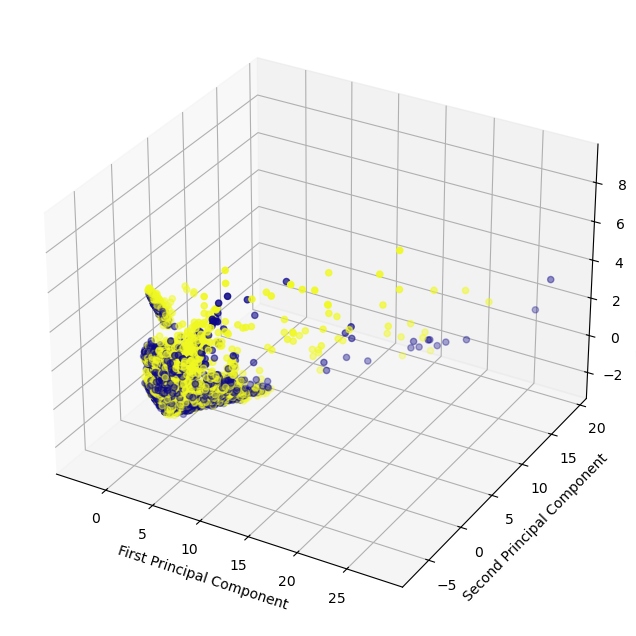

In [39]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming x_pca has three columns for the three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2],
           c=target,
           cmap='plasma')

# labeling axes
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

plt.show()


In [21]:
from sklearn.model_selection import train_test_split
y=df['user-definedlabeln']
X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [23]:
svm_classifier = SVC(random_state=108)

# Train the classifier on the training data
svm_classifier.fit(X_train, Y_train)

SVC(random_state=108)

In [24]:
predictions = svm_classifier.predict(x_test).astype(int)
predictions

array([0, 1, 1, ..., 0, 0, 0])

In [25]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.6588609424689217

In [26]:
from sklearn.metrics import confusion_matrix

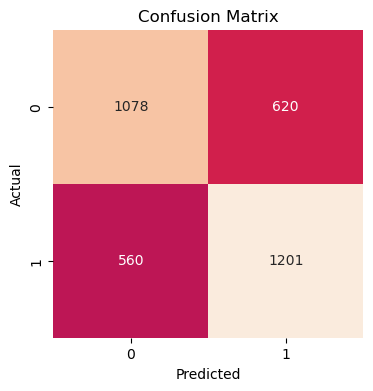

In [27]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks,layers

In [29]:
inputs = tf.keras.Input(shape=(X_train.shape[1]))
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model=tf.keras.Model(inputs,outputs)
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]
             )
batch_size=32
epochs=50
history=model.fit(
            X_train,
            Y_train,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

2023-12-03 22:01:54.876801: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
234/234 [==============================] - 7s 26ms/step - loss: 0.6549 - accuracy: 0.6126 - auc: 0.6573 - val_loss: 0.6484 - val_accuracy: 0.6264 - val_auc: 0.6783 - lr: 0.0010
Epoch 2/50
234/234 [==============================] - 6s 25ms/step - loss: 0.6377 - accuracy: 0.6240 - auc: 0.6812 - val_loss: 0.6408 - val_accuracy: 0.6227 - val_auc: 0.6820 - lr: 0.0010
Epoch 3/50
234/234 [==============================] - 7s 29ms/step - loss: 0.6314 - accuracy: 0.6380 - auc: 0.6924 - val_loss: 0.6377 - val_accuracy: 0.6403 - val_auc: 0.6864 - lr: 0.0010
Epoch 4/50
234/234 [==============================] - 5s 21ms/step - loss: 0.6254 - accuracy: 0.6418 - auc: 0.7001 - val_loss: 0.6494 - val_accuracy: 0.6350 - val_auc: 0.6942 - lr: 0.0010
Epoch 5/50
234/234 [==============================] - 5s 22ms/step - loss: 0.6214 - accuracy: 0.6525 - auc: 0.7068 - val_loss: 0.6348 - val_accuracy: 0.6339 - val_auc: 0.6885 - lr: 0.0010
Epoch 6/50
234/234 [==============================] - 5s 20m

In [30]:
model.evaluate(x_test,y_test)

109/109 [==============================] - 1s 12ms/step - loss: 0.6377 - accuracy: 0.6577 - auc: 0.7175


[0.637686014175415, 0.6577045321464539, 0.7174599766731262]

In [31]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(x_test))
y_pred = np.array(y_pred >=0.5, dtype=np.int)
y_pred

109/109 [==============================] - 2s 14ms/step


/tmp/ipykernel_1794/295032384.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.array(y_pred >=0.5, dtype=np.int)


array([1, 0, 1, ..., 0, 1, 0])

In [32]:
accuracyKeras=accuracy_score(y_true, y_pred)
accuracyKeras

0.6577045388840705